# Выращиваем решающее дерево своими руками

### OzonMasters, "Машинное обучение 1"

В этом ноутбуке вам предлагается реализовать решающее дерево.

## Введение

Для начала импортируем библиотеки, которые нам понадобятся в дальнейшем:

In [1]:
import numpy as np

from sklearn.metrics import accuracy_score

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## 1. Построение критерия и вычисление предиката

В данном пункте предлагается:
- реализовать метод `get_best_split` у абстрактного класса `Criterion`, который выполняет поиск порога разбиения $\beta$ по вектору признаков;
- для каждого из критериев `GiniCriterion`, `EntropyCriterion`, `MSECriterion` реализовать два метода:
    - `score`, считает чистоту узла, т.е. непосредственно сам критерий $H(R)$;
    - `get_predict_val`, вычисляет предсказанное значение в листе.

In [2]:
class Criterion:

    def get_best_split(self, feature, target):
        """
        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """

        size = len(feature)
        init_score = self.score(target)
        sort_ids = np.argsort(feature)

        best_score = -np.inf
        best_i = None

        for i in range(len(feature)):
            left_size = i + 1
            left_ids = sort_ids[:i + 1]

            right_size = size - i - 1
            right_ids = sort_ids[i + 1:]

            left_score = left_size / size * self.score(target[left_ids])
            right_score = right_size / size * self.score(target[right_ids])

            score = init_score - left_score - right_score

            if score > best_score:
                best_score = score
                best_i = i

        best_threshold = (feature[sort_ids[best_i]] + feature[sort_ids[best_i + 1]]) / 2

        return best_threshold, best_score


    def score(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """

        raise NotImplementedError

    def get_predict_val(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: probability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """

        raise NotImplementedError


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes
    
    def get_predict_val(self, classes):
        if len(classes) == 0:
            return np.zeros(0)

        pred = np.bincount(classes, minlength = self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - (pred ** 2).sum()
        

class EntropyCriterion(Criterion):
    EPS = 1e-6
    
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength = self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return (-pred*np.log(pred + self.EPS)).sum()


class MSECriterion(Criterion):
    def get_predict_val(self, target):
        return np.mean(target)

    def score(self, target):
        return np.var(target)

Проверь себя:

In [3]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).get_predict_val(target)
assert np.allclose(y_pred, y_true)

In [4]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).score(target)
assert np.isclose(scores, 0.74)

In [5]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_best_split(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

## 2. Вычисление параметров предиката и разбиение вершины дерева

Ниже вам предлагается реализовать несколько методов. Для класса `TreeNode` необходимо реализовать методы:
* `get_best_split` - вычисление оптимальных $\alpha$, $\beta$ для выбранного функционалиа $Q(R, \alpha, \beta)$;
* `split` – разбиение узла с заданными подобранными параметрами.

In [6]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity        # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth              # current node depth
        
        self.feature = None             # feature to split
        self.threshold = None           # threshold to split
        self.improvement = -np.inf      # node impurity improvement after split
        
        self.child_left = None
        self.child_right = None
    
    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None
    
    @classmethod
    def get_best_split(cls, X, y, criterion):
        '''
        Finds best split for current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        
        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        '''

        q_best = - np.inf
        t_best = None
        f_best = None
        
        for fi in range(X.shape[1]):
            thr, q = criterion.get_best_split(X[:,fi], y)
            if q > q_best:
                q_best = q
                t_best = thr
                f_best = fi
    
        return f_best, t_best, q_best
      

    def get_best_split_mask(self, X):
        '''
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        '''

        return X[:, self.feature] >= self.threshold
    
    def split(self, X, y, criterion, **split_params):
        '''
        Split current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
            
        child_left  : TreeNode
        child_right : TreeNode
        '''
        
        self.feature = split_params['feature']
        self.threshold = split_params['threshold']
        self.improvement = split_params['improvement']
        
        mask_right = self.get_best_split_mask(X)
        self.child_left = self.from_criterion(y[~mask_right], criterion, self.depth + 1)
        self.child_right = self.from_criterion(y[mask_right], criterion, self.depth + 1)
        
        return mask_right, self.child_left, self.child_right
            
    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )

Проверьте себя:

In [7]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [8]:
best_feature, best_threshold, improvement = TreeNode.get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert improvement == 0.5

############
(0.035373495255063614, 0.02083333333333337)
############
############
(0.9777234485742468, 0.015463917525773196)
############
############
(0.22543170260923845, 0.021600000000000064)
############
############
(49.5, 0.5)
############
############
(0.19510241775096315, 0.014767932489451463)
############
############
(0.9480668562676979, 0.014184397163120647)
############
############
(0.905375679973802, 0.03555555555555547)
############
############
(0.032847234366134626, 0.015463917525773196)
############
############
(0.08039667017094587, 0.025025536261491288)
############
############
(0.42395674153938584, 0.01282051282051283)
############


## 3. Реализация дерева.

Вот мы и добрались до самого важного. В классе `DecisionTree` вам необходимо реализовать следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [9]:
from collections import deque


class DecisionTree:
    def __init__(self, max_depth=None, min_leaf_size=None, min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement

    def _build_nodes(self, X, y, criterion, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        
        if self.max_depth is not None and node.depth >= self.max_depth:
            return
        
        if self.min_leaf_size is not None and self.min_leaf_size > len(indices):
            return
        
        if np.unique(y[indices]).shape[0] <= 1:
            return

        X_node = X[indices]
        y_node = y[indices]

        feature, threshold, improvement = node.get_best_split(X_node, y_node, criterion)

        if self.min_improvement is not None and self.min_improvement > improvement:
            return

        mask_right, child_left, child_right = node.split(
            X_node, y_node, criterion,
            feature=feature,
            threshold=threshold,
            improvement=improvement
        )

        self._build_nodes(X, y, criterion, indices[~mask_right], child_left)
        self._build_nodes(X, y, criterion, indices[mask_right], child_right)


    def _get_nodes_predictions(self, X, predictions, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''

        if len(indices) == 0:
            return

        if node.is_terminal:
            predictions[indices] = node.predict_val
            return

        feature = node.feature
        threshold = node.threshold
        mask_right = X[indices, feature] >= threshold

        indices_left = indices[~mask_right]
        indices_right = indices[mask_right]

        self._get_nodes_predictions(X, predictions, indices_left, node.child_left)
        self._get_nodes_predictions(X, predictions, indices_right, node.child_right)
        

    @property
    def feature_importances_(self):
        '''
        Returns
        -------
        importance : cummulative improvement per feature, np.ndarray.shape = (n_features, )
        '''

        importance = np.zeros(self.n_features_)
        quene = deque()
        quene.append(self.root_)
        
        while len(quene):
            node = quene.popleft()
            if node.is_terminal:
                continue
                
            importance[node.feature] += node.improvement
            quene.append(node.child_left)
            quene.append(node.child_right)
            
        return importance


А теперь на основе реализованного в общем виде дерева, сделаем дерево для классификации:

In [10]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('gini', 'entropy', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

Проверь себя:

In [11]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

############
(0.18974814492694403, 0.25)
############
############
(-0.0032549951036895397, 0.25)
############
############
(-5.008412063984682, 0.01284624648735444)
############
############
(0.30188020515620373, 0.5)
############
############
(6.642794525254121, 0.022163120567375832)
############
############
(-0.060011345638550706, 0.5)
############


In [12]:
some_X.shape, some_y.shape

((400, 2), (400,))

In [13]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [14]:
assert (some_tree.feature_importances_ == [0.25, 1.  ]).all()

Ещё одна проверка:

In [15]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

############
(-0.1942590187865212, 0.25)
############
############
(-0.32860418319509077, 0.25)
############
############
(0.10034997256230671, 0.007214513712461845)
############
############
(0.12104035795671009, 0.006320939334638065)
############
############
(0.8391407295111719, 0.0077106030382077945)
############
############
(0.7119506751051954, 0.004597908402452305)
############
############
(0.9674425395511939, 0.004124428543033243)
############
############
(0.45222444784004207, 0.008432589330397366)
############
############
(0.38944225052755976, 0.0056033709879863)
############
############
(0.07519692324366606, 0.005593437033880266)
############
############
(0.9744305484195783, 0.005739795918367397)
############
############
(0.029249908483244047, 0.004632034632034543)
############
############
(0.6618756348960559, 0.005822036843934564)
############
############
(0.7671080209911003, 0.009629679686444098)
############
############
(0.9035397608226452, 0.004974207811348594)
#

In [16]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

## 4. Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

In [17]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

Функция для визуализации двумерной выборки:

In [18]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Функция для визуализации работы дерева на двумерной выборке:

In [19]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

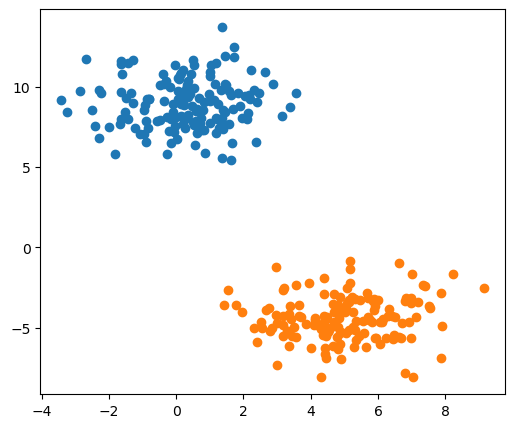

In [20]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)
plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [21]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

############
(2.495892075794897, 0.4293746388728389)
############
############
(2.2811930741542374, 0.5)
############


Если вы всё реализовали правильно, то должно получиться что-то такое:

Accuracy = 1.0


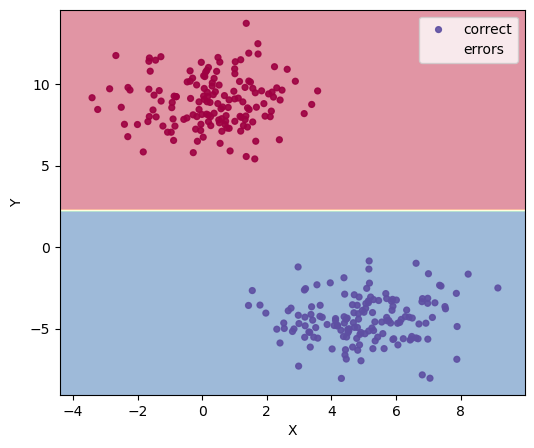

In [22]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [23]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

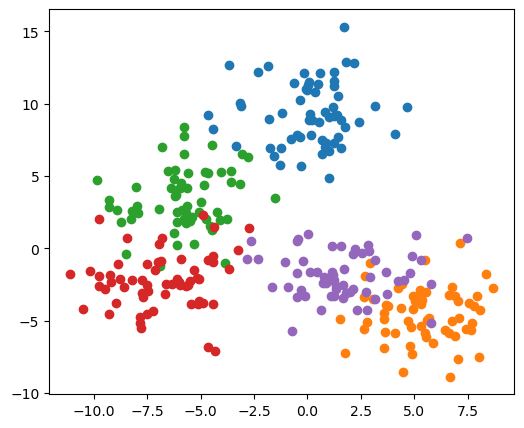

In [24]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
Accuracy = 0.4


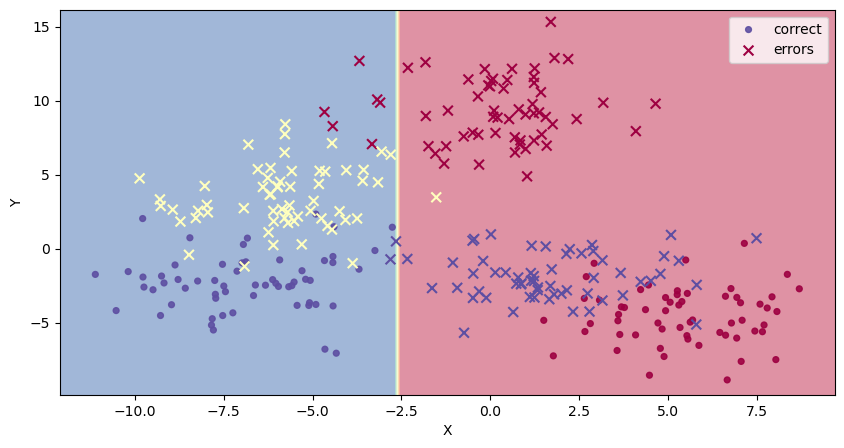

In [25]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
############
(-6.575307438014049, 0.053787041882279896)
############
############
(1.509150942709334, 0.32514716324240134)
############
############
(2.6027106698964433, 0.19806904614345708)
############
############
(4.1762503143043785, 0.31929250891795485)
############
Accuracy = 0.7466666666666667


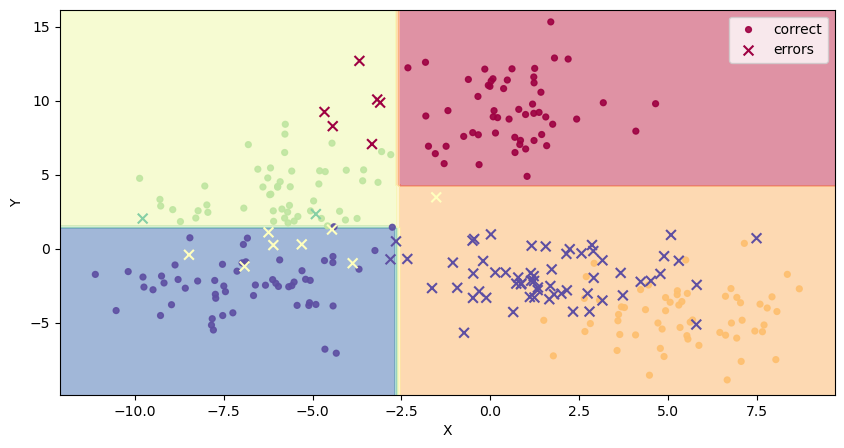

In [26]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
############
(-6.575307438014049, 0.053787041882279896)
############
############
(1.509150942709334, 0.32514716324240134)
############
############
(-3.028329939063852, 0.01218147382920122)
############
############
(-1.2930948762501826, 0.05234159779614342)
############
############
(-4.7093145335734885, 0.040952380952380935)
############
############
(8.004195514521873, 0.11432098765432089)
############
############
(2.6027106698964433, 0.19806904614345708)
############
############
(4.1762503143043785, 0.31929250891795485)
############
############
(2.6027106698964433, 0.2318985911749069)
############
############
(-3.5363288093695724, 0.19537019495449973)
############
Accuracy = 0.89


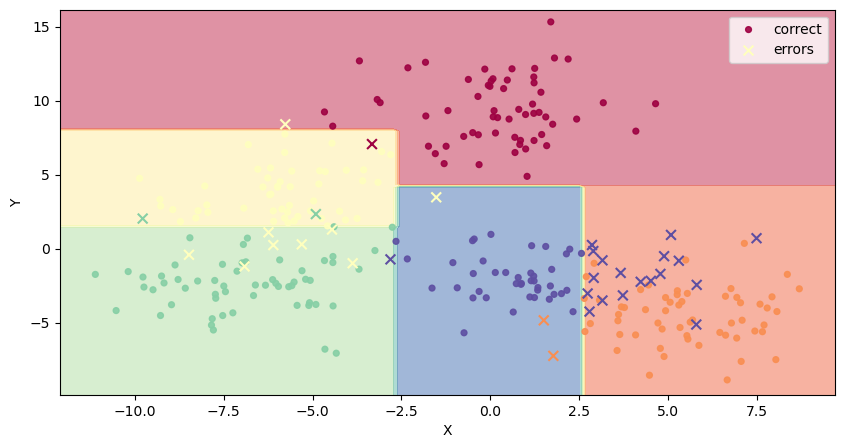

In [27]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
############
(-6.575307438014049, 0.053787041882279896)
############
############
(1.509150942709334, 0.32514716324240134)
############
############
(-3.028329939063852, 0.01218147382920122)
############
############
(-1.2930948762501826, 0.05234159779614342)
############
############
(-3.028329939063852, 0.032644628099173525)
############
############
(-1.1507489159239288, 0.041519086973632324)
############
############
(-6.537337817122988, 0.04399965114250831)
############
############
(-0.47034404550880105, 0.05001030715316429)
############
############
(-4.7093145335734885, 0.040952380952380935)
############
############
(8.004195514521873, 0.11432098765432089)
############
############
(-9.537314895688922, 0.015854173261580798)
############
############
(7.044181470942698, 0.01044944726861946)
############
############
(-9.823124148002552, 0.5)
###

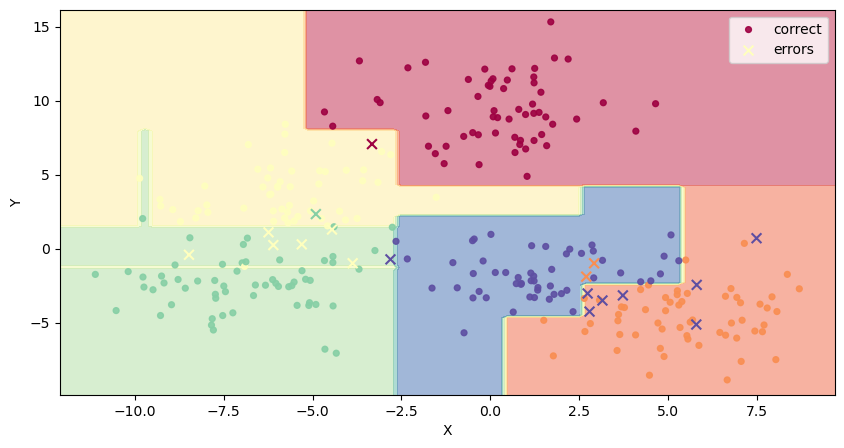

In [28]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
############
(-6.575307438014049, 0.053787041882279896)
############
############
(1.509150942709334, 0.32514716324240134)
############
############
(-3.028329939063852, 0.01218147382920122)
############
############
(-1.2930948762501826, 0.05234159779614342)
############
############
(-3.028329939063852, 0.032644628099173525)
############
############
(-1.1507489159239288, 0.041519086973632324)
############
############
(-6.537337817122988, 0.04399965114250831)
############
############
(-0.47034404550880105, 0.05001030715316429)
############
############
(-4.150688420167934, 0.23999999999999985)
############
############
(-0.7413709183525456, 0.06499999999999984)
############
############
(-3.3417431509662814, 0.5)
############
############
(-0.853547745752947, 0.5)
############
############
(-4.426460802457761, 0.1549586776859505)
############
######

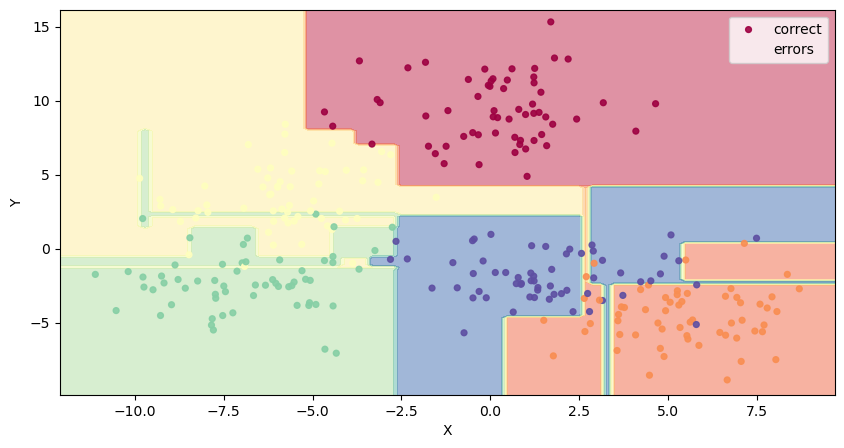

In [29]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
############
(-6.575307438014049, 0.053787041882279896)
############
############
(1.509150942709334, 0.32514716324240134)
############
############
(-3.028329939063852, 0.01218147382920122)
############
############
(-1.2930948762501826, 0.05234159779614342)
############
############
(-3.028329939063852, 0.032644628099173525)
############
############
(-1.1507489159239288, 0.041519086973632324)
############
############
(-6.537337817122988, 0.04399965114250831)
############
############
(-0.47034404550880105, 0.05001030715316429)
############
############
(-4.150688420167934, 0.23999999999999985)
############
############
(-0.7413709183525456, 0.06499999999999984)
############
############
(-4.426460802457761, 0.1549586776859505)
############
############
(1.3685161270928001, 0.09182736455463741)
############
############
(-4.7093145335734885, 0.040952

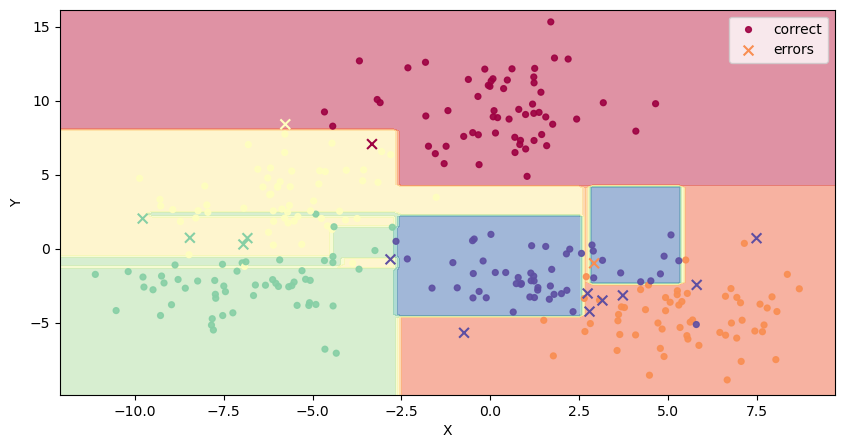

In [30]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

############
(-2.706110303344301, 0.17983944535668667)
############
############
(1.509150942709334, 0.17710928319623967)
############
############
(-6.575307438014049, 0.053787041882279896)
############
############
(1.509150942709334, 0.32514716324240134)
############
############
(-3.028329939063852, 0.01218147382920122)
############
############
(-1.2930948762501826, 0.05234159779614342)
############
############
(-4.7093145335734885, 0.040952380952380935)
############
############
(8.004195514521873, 0.11432098765432089)
############
############
(-9.537314895688922, 0.015854173261580798)
############
############
(7.044181470942698, 0.01044944726861946)
############
############
(-5.21747234575655, 0.2777777777777777)
############
############
(8.816642794278785, 0.11111111111111102)
############
############
(2.6027106698964433, 0.19806904614345708)
############
############
(4.1762503143043785, 0.31929250891795485)
############
############
(2.6027106698964433, 0.23189859117490

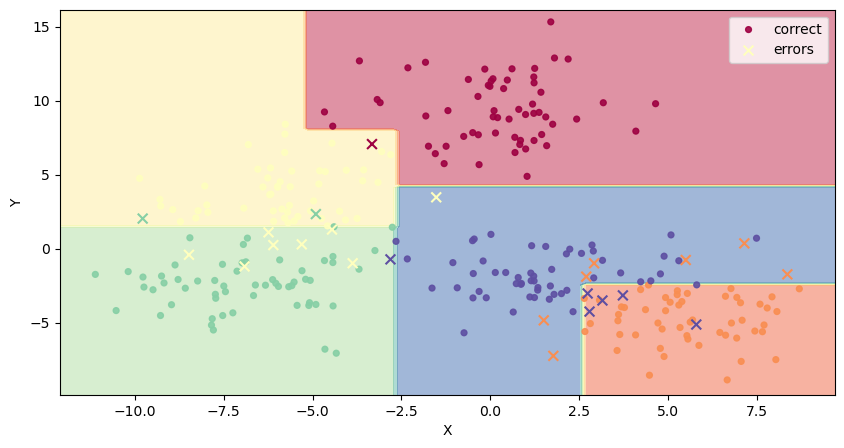

In [31]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

## Домашнее задание (10 баллов)

1. (4 балла) Доделать все пункты ноутбука до конца

2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:
    $$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$
    
    Докажите, что минимум H(R) достигается при $c$:

    $$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.

    Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.
    
    
3. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.


Бонусных баллов в этот раз нет :)

1. (4 балла) Доделать все пункты ноутбука до конца  
- Done?


2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:
    $$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$
    
    Докажите, что минимум H(R) достигается при $c$:

    $$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

Легко видеть, что у функции $f(c) = \frac{1}{|R|} \sum_{x_i, y_i} (y_i - c)^2$ есть минимум и нет максимума.  
Найдем $ 0 = f'(c_0) = \frac{1}{|R|} \sum_{y_i} 2(y_i - c_0)$.  
Следовательно $\sum_{y_i} (y_i - c_0) = 0$  
$c = \frac{1}{|R|} \sum_{y_i} y_i$


3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.

    Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.
    


In [32]:
class RegressionDecisionTree(DecisionTree):
    def __init__(self, criterion='MSE', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('MSE', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'MSE':
            criterion = MSECriterion()
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        self._get_nodes_predictions(X, predictions, np.arange(X.shape[0]), self.root_)
        return predictions

In [33]:
some_tree = RegressionDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

############
(-3.688968040311334, 0.13752122241086595)
############
############
(5.562939297575995, 0.9015799015799018)
############
############
(3.3593176323969294, 0.35416670099531095)
############
############
(-4.773553972046612, 0.22619688004303362)
############
############
(-2.985056413295915, 0.20633602207932766)
############
############
(1.0339107096242937, 0.3077542236448036)
############
############
(-3.028329939063852, 0.1090765375157483)
############
############
(-4.785111033351344, 0.08507549794852509)
############
############
(-4.104080832208884, 0.0032681858479520817)
############
############
(-1.2930948762501826, 0.017389379831481075)
############
############
(-6.931031080999299, 0.008860228583411928)
############
############
(-1.1507489159239288, 0.031141868512110704)
############
############
(-6.469716200120102, 0.015625)
############
############
(-0.47034404550880105, 0.024801587301587324)
############
############
(2.6027106698964433, 0.2743157119888424)

/home/denis/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/denis/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/denis/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


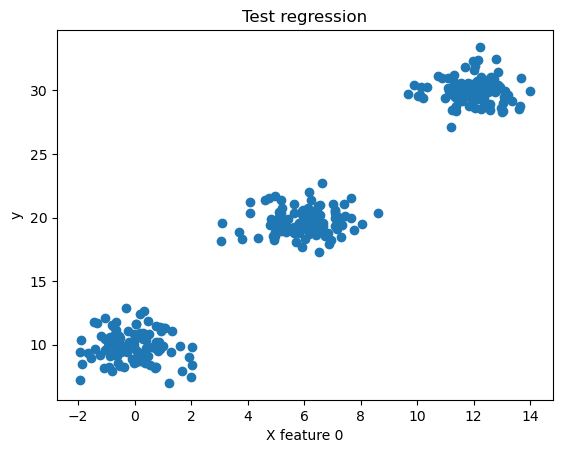

In [34]:
X = np.concatenate([
    np.random.normal(loc=0, size=(100, 1)),
    np.random.normal(loc=6, size=(100, 1)),
    np.random.normal(loc=12, size=(100, 1)),
])

y = np.concatenate([
    np.random.normal(10, size=100),
    np.random.normal(20, size=100),
    np.random.normal(30, size=100),
])

plt.scatter(X[:, 0], y)
plt.title('Test regression')
plt.xlabel('X feature 0')
plt.ylabel('y')
plt.show()

    
3. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.
